# Biometric Steganography using Hand Geometry

In [1]:
from PIL import Image
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import binascii
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import imutils


In [2]:
def displayImage(name,data):
 
    '''
     Input:- Image-name, image-path to be display
     Output:- Display image on separate window
 
    '''
    cv2.imshow(name, data)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Step 1: Image Preprocessing

In [3]:
'''
 --Acquired the coloured hand image
 --resize the image 
 --rotate the image by -90-degree
 
'''
originalImage = cv2.imread('hand.jpg')
resizedImage1 = cv2.resize(originalImage, (200,200))
resizedImage = imutils.rotate(resizedImage1, -90)
#displayImage("resized",resizedImage)


In [4]:
'''
  convert the hand-image into Gray image 
  
'''
#convert the image into GrayImage
grayImage = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2GRAY)

#convert the image into black and white
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
 
#displayImage('Black white image', blackAndWhiteImage)
#displayImage('Original image',resizedImage)
#displayImage('Gray image', grayImage)

In [5]:
'''
Gaussian filter had used to remove the background noise of the image

'''
#median filter 
median = cv2.medianBlur(resizedImage, 5)
compare = np.concatenate((resizedImage, median), axis=1) #side by side comparison
#displayImage('img', compare)

#gaussian filtering
blur = cv2.GaussianBlur(grayImage,(5,5),0)
#displayImage("Gaussianblur",blur)


In [6]:
'''
hand image is changed over to the “binary image” by thresholding
# applying Otsu thresholding 
# as an extra flag in binary  
# thresholding
'''
ret, thresh1 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY +  cv2.THRESH_OTSU) 
#displayImage('Otsu Threshold', thresh1)          

ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Step 2: Feature Extraction


In [7]:
'''
Boundary Tracing of the preprocessed hand image
-trace contours of image used to plot all the contours point
'''

cnts = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(cnts)

cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)


# determine the most extreme points along the contour
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# draw the outline of the object, then draw each of the
# extreme points, where the left-most is red, right-most
# is green, top-most is blue, and bottom-most is teal
cv2.drawContours(thresh1, [c], -1, (125, 125, 125), 2)
cv2.circle(thresh1, extLeft, 8, (50, 50, 50), -1)
cv2.circle(thresh1, extRight, 8, (50, 50, 50), -1)
cv2.circle(thresh1, extTop, 8, (50, 50, 50), -1)
cv2.circle(thresh1, extBot, 8, (50, 50, 50), -1)

#displayImage("Image", thresh1)




array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

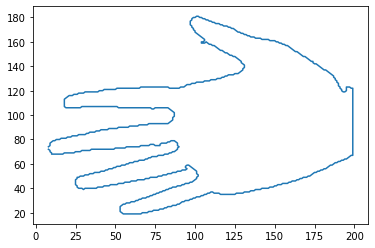

In [8]:
#print all the contours point
items = [tuple(item[0]) for npar in cnts for item in npar]

#print(items)

xRes = [lis[0] for lis in items]
yRes = [lis[1] for lis in items]

plt.plot(yRes,xRes)


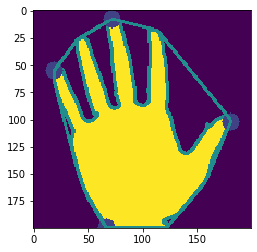

In [9]:
'''
- Detect the convex contour
- find the X-Y coordinates of hand image
- find convex hull
'''

hull = cv2.convexHull(cnts[0])

#print(hull)

xhull = [item[0] for sublist in hull for item in sublist]
yhull = [item[1] for sublist in hull for item in sublist]
#print('convexHull-X-coord:= ',xhull)
#print('convexHull-Y-coord:= ',yhull)

img_copy = thresh1.copy()
img_hull = cv2.drawContours(img_copy, contours = [hull], 
                            contourIdx = 0, 
                            color = (125, 125, 125), thickness = 2)
plt.imshow(img_hull)



In [10]:
'''
- find the coordinates of center point for hand image
- highlight the center point
'''
# calculate moments of binary image
M = cv2.moments(th3)
 
# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
#print("cX",cX) 
#print("cY",cY) 

# put text and highlight the center
cv2.circle(th3, (cX, cY), 5, (125, 125, 255), -1)
cv2.putText(th3, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
 
# display the image
# displayImage("Image", th3)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Text(0, 0.5, 'xhull')

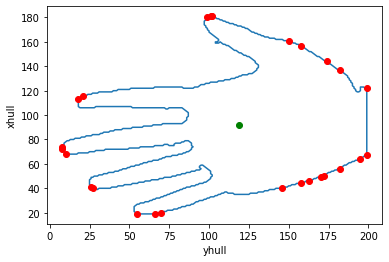

In [11]:
'''
- plot the X-Y coordinates of contours point and center point
'''

plt.plot(yRes,xRes)
plt.plot(yhull,xhull,'ro')
plt.plot(cY,cX,'go')
plt.xlabel("yhull")
plt.ylabel("xhull")

Text(0, 0.5, 'xhullupdated')

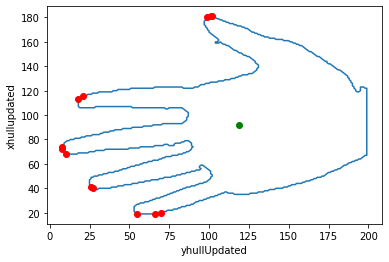

In [12]:
'''
 To find the tips and valley point from hand geometry
 Consider the points above the center point which indicate the tip points
'''

#only take the coordinates of tip points
xhullUpdated = []
yhullUpdated = []
t=0;
for i in yhull:
    if(i<cY):
        yhullUpdated.append(i)
        xhullUpdated.append(xhull[t])
    t=t+1

plt.plot(yRes,xRes)
plt.plot(yhullUpdated,xhullUpdated,'ro')
plt.plot(cY,cX,'go')
plt.xlabel("yhullUpdated")
plt.ylabel("xhullupdated")

#print('yhullUpdated',yhullUpdated)
#print('xhullUpdated',xhullUpdated)

# Step 3: Key Generation

In [13]:
'''
Euclidean distance between center point and all other points of convex hull(tips point)

'''
distVector = []
length=int(len(yhullUpdated))
for i in range(length):
    distVector.append(np.sqrt( (xhullUpdated[i]-cX)**2 + (yhullUpdated[i]-cY)**2 ))
    #distVector.append(dist)

#print(distVector)

In [14]:
'''
Variance and standard deviation is calculated for pairwise Euclidean distance
'''
import statistics 

variance = statistics.variance(distVector)
std_dev = statistics.stdev(distVector)
#print("Variance of sample set is % s"  %(variance))
#print("Standard Deviation of sample is % s " %(std_dev)) 

In [15]:
'''
Unique 4 digit key generation
Key= (Most Significant 2 Digits of p1) * 100 + (Least Significant 1 Digits p2)
Where
P1 = variance of Hand points pairs wise distance
P2 = standard deviation of Hand points pairs wise distance

'''
MSB = int(str(variance)[:2])
LSB = int(str(std_dev)[-1:])
#print(MSB,LSB)
key = (MSB)* 10 + (LSB)
print("Key Generated:- ",key)

Key Generated:-  898


# Step 4: Data Embedding 


In [16]:
'''
- First carrier image or cover image has been read and converted in to array of bits
- the secret message which is in the form of characters are converted in to the “ASCII” values
- ASCII values are converted in to array of bits
- key will gives unique pixel position of cover image to embed the data LSB of particular image pixel of cover object

Output: Stego-image has been generated which contains secret message embedded within cover image.

'''
res = input("Enter data to be encoded(Without Space) : ") 
data = ''.join(format(ord(i), 'b') for i in res) 
#print("The string after binary conversion : " + data) 
msg_len = len(data)
#print("msg length",msg_len)
    
i=0

with Image.open("source_img.png") as img:
    width, height = img.size
    #print(width)
    #print(height)
    #img.show()
    for x in range(key, width):
        for y in range(key, height):
            pixel = list(img.getpixel((x, y)))
            for n in range(0,3):
                if(i < len(data)):
                    pixel[n] = pixel[n] & ~1 | int(data[i])
                    i+=1
            img.putpixel((x,y), tuple(pixel))
    img.save("source_secret.png", "PNG")
        

Enter data to be encoded(Without Space) : anu


# Step 5: Data Extraction

In [17]:
'''
- Embedded secret data has extracted from stego-image
- Extracting secret data the hand key is used

'''
extracted_bin = []
with Image.open("source_secret.png") as img:
    width, height = img.size
    byte = []
    for x in range(key, width):
        for y in range(key, height):
            pixel = list(img.getpixel((x, y)))
            for n in range(0,3):
                extracted_bin.append(pixel[n]&1)

data = "".join([str(x) for x in extracted_bin])
msg =''

for i in range(msg_len):
    msg+=str(extracted_bin[i])
#print(msg)

decoded_msg = ''.join(chr(int(msg[i*7:i*7+7],2)) for i in range(len(msg)//7))
print("decoded_msg:= ",decoded_msg)


decoded_msg:=  anu
